In [1]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
import mat73
from matplotlib import colors
from cycler import cycler
from google.colab import drive

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

     |████████████████████████████████| 137 kB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 34.4 MB/s 
     |████████████████████████████████| 209 kB 43.9 MB/s 
     |████████████████████████████████| 12.5 MB 36.9 MB/s 
     |████████████████████████████████| 109 kB 22.6 MB/s 
     |████████████████████████████████| 51 kB 309 kB/s 
     |████████████████████████████████| 251 kB 8.6 MB/s 
     |████████████████████████████████| 546 kB 31.0 MB/s 
     |████████████████████████████████| 462 kB 38.4 MB/s 
  Created wheel for pydeepimagej: filename=pydeepimagej-2.3.3-py3-none-any.whl size=24230 sha256=24bda9aabdad97587d8b09d80fcde3340fb1f08c2ef36972417ce962ac106fb7
  Stored in directory: /root/.cache/pip/wheels/4a/05/98/e4bba4aca59759f5e635d6de7d953a9c60a3db586dd2d96dee
Successfully built pydeepimagej
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
E

In [2]:
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

drive.mount('/content/drive')
filePath = "/content/drive/My Drive/Kandidatarbete/data/isak/traces64x64ROI.mat"

data = mat73.loadmat(filePath)
data = data['CompletedTraces']

shape = [64, 64]
realM = np.zeros((len(data), 64, 64, 1))
imagM = 1j * np.ones((len(data), 64, 64, 1))

Mounted at /content/drive


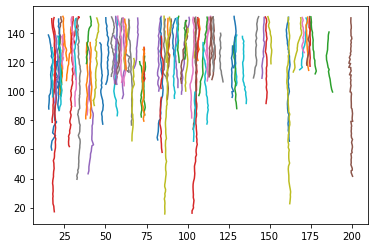

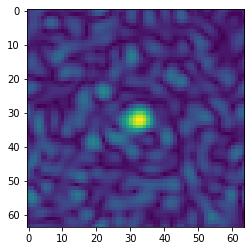

In [3]:
"""Saves images and positions for individual particles."""
particles_timeseries = []
particles_positions = []
num_particles = 100
IMAGE_SIZE = 64

for i in range(num_particles):
    frames = data[i]["Positions"][:,0].astype(int)
    positions = data[i]["Positions"][:,1:4]
    particles_positions.append(positions)

    roi_data = np.array(data[i]['ROI'][0])
    timeseries = []
    for j in range(roi_data.shape[0]):
        particleROI = np.fft.ifft2(exp_expand(roi_data[j,:], shape))
        particleROI = np.fft.fftshift(particleROI)
        particleROI = np.expand_dims(particleROI, axis = -1)
        timeseries.append(particleROI)
    particles_timeseries.append(np.array(timeseries))

for particle_id in range(num_particles):
    plt.plot(particles_positions[particle_id][:,0], particles_positions[particle_id][:,1])
plt.show()

for _ in range(1):
    plt.imshow(np.abs(particles_timeseries[0][_,:,:,0]))
    plt.show()

training images shape (13, 64, 64, 2)
validation images shape (64, 64, 64, 1)


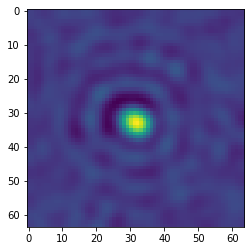

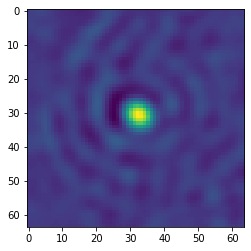

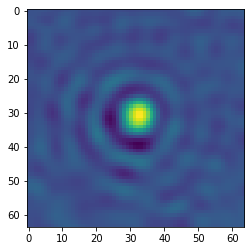

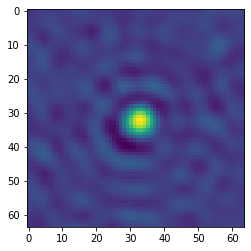

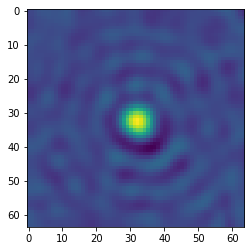

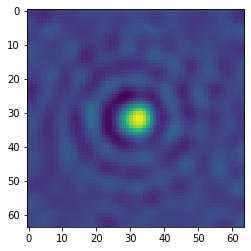

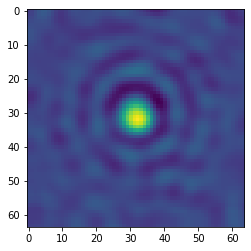

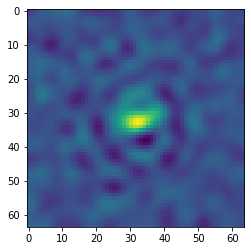

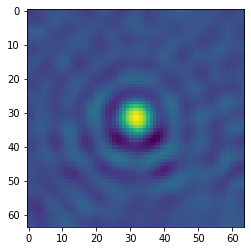

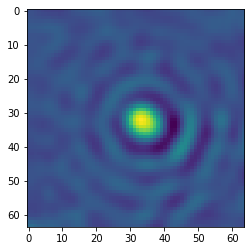

In [4]:
particle_id = 10
training_images = np.stack((np.real(particles_timeseries[particle_id])[::5,:,:,0], np.imag(particles_timeseries[particle_id][::5,:,:,0])), axis=-1)
print(f"training images shape {training_images.shape}")
validation_set = particles_timeseries[particle_id][:,:,:,:]
print(f"validation images shape {validation_set.shape}")

"""Create group/equivariance"""

crop_size = 64
padding = 32
wavelength = 525e-9
pixel_size = 114e-9 #??
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

args = dt.Arguments(
    translate=lambda: np.random.randn(2)*0.5,
    rotate=lambda: np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randn(1)*20,
)

group = ( 
    dt.Affine(rotate=args.rotate) 
    >> dt.Affine(translate=args.translate) 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.00)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
)

equivariance = (
    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    >> dt.models.lodestar.Equivariance(1, args.z/10, indexes=2)
)

import random
def create_training_set(training_images):
    return dt.Value(lambda: random.choice(training_images))

training_set = create_training_set(training_images)

for _ in range(10):
    x = (training_set>>group).update()()
    plt.imshow(x[..., 1])
    plt.show()


In [5]:
#@title
"""Create custom layers"""
from tensorflow.math import abs, angle, real, imag, subtract, multiply

class CustomLayerOne(keras.layers.Layer):
    "Dpes nothing"
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), angle(image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerTwo(keras.layers.Layer):
    "Takes 2 layers as input and outputs 3 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), abs(norm_image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerThree(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [6]:
#@title
"""Create models"""
num_outputs = 3

def create_model(custom_layer, nlayers):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(32, 3, activation='relu', strides=(2,2)))
    for _ in range(nlayers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": nlayers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model

models = [create_model(CustomLayerThree(), 1)]


In [7]:
"""Create generator"""
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    num_outputs=num_outputs, 
    transformation_function=(group, equivariance), 
    batch_size=8, 
    min_data_size=100, 
    max_data_size=201,
)

Generating 100 / 100 samples before starting training


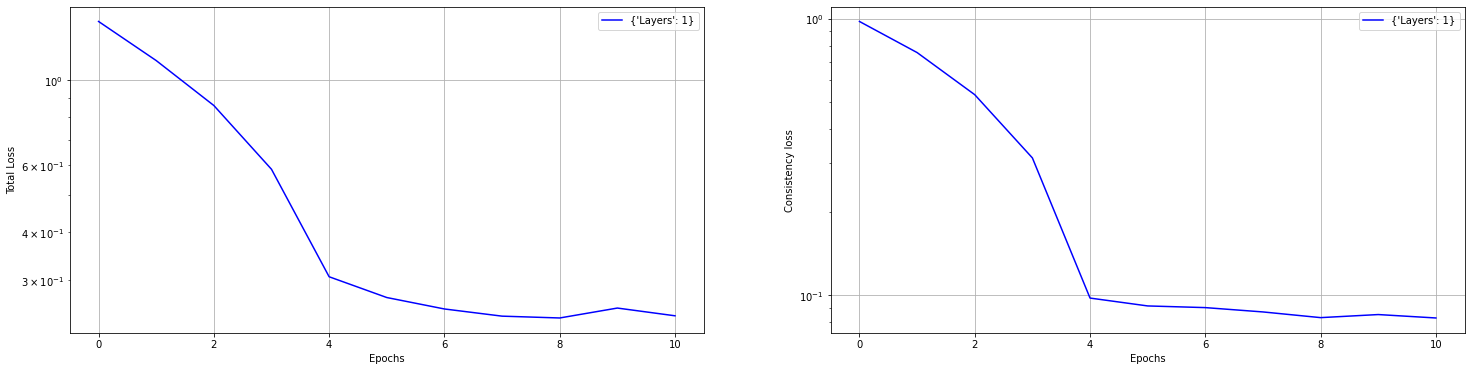

Generating 196 / 100 samples before starting training


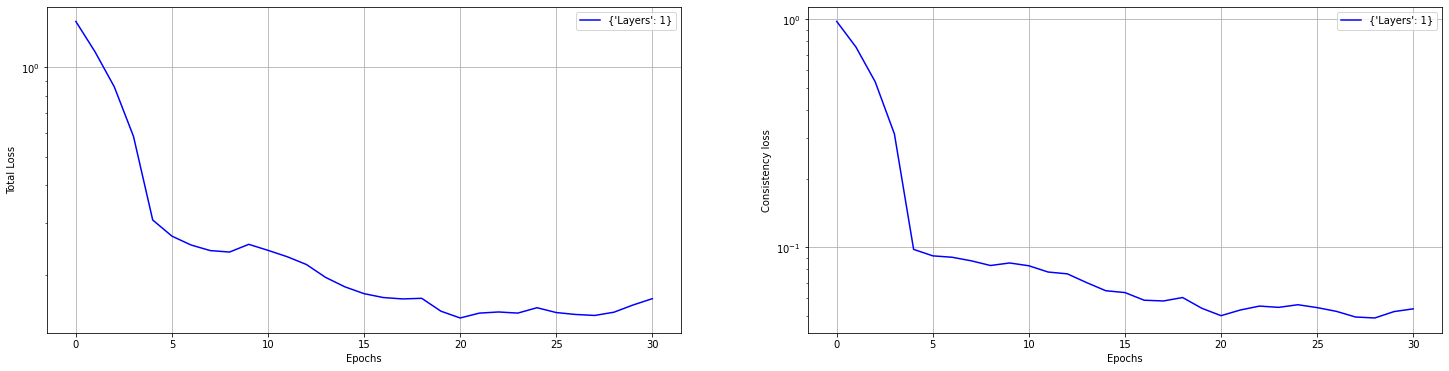

Generating 201 / 100 samples before starting training


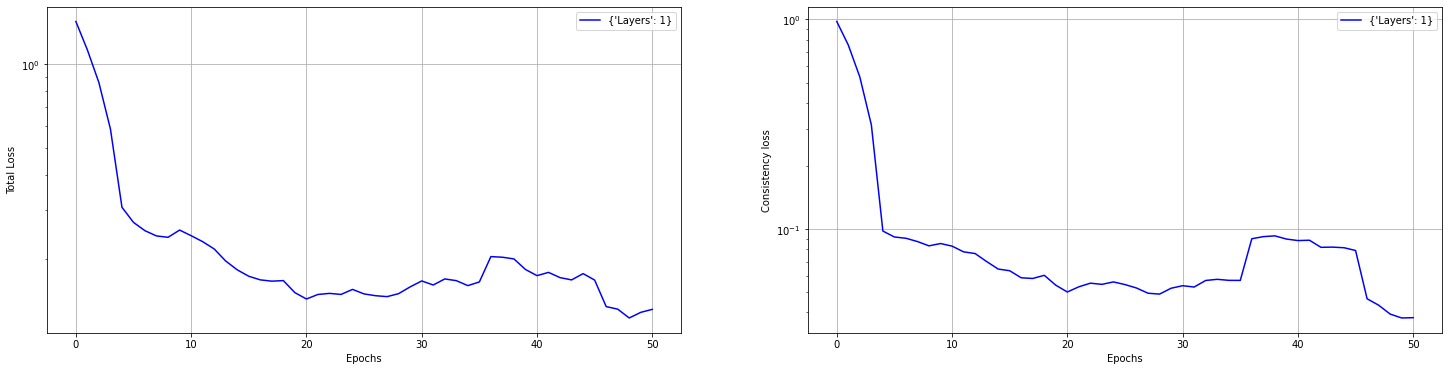

Generating 200 / 100 samples before starting training


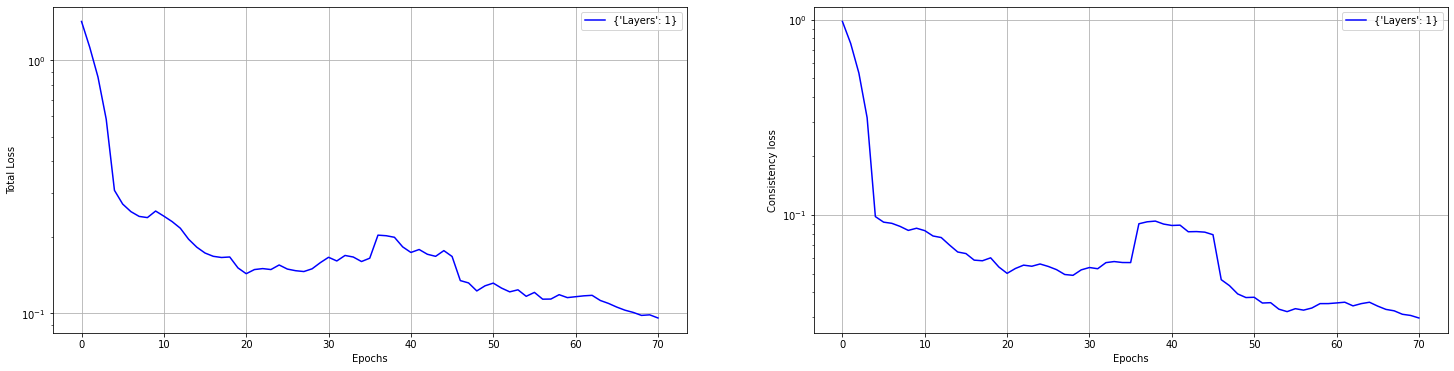

Generating 201 / 100 samples before starting training


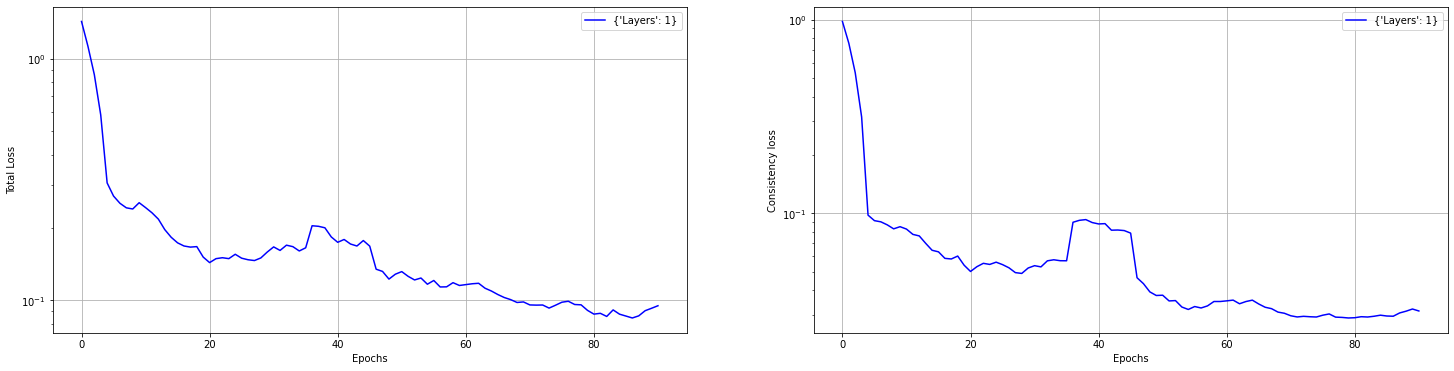

Generating 201 / 100 samples before starting training


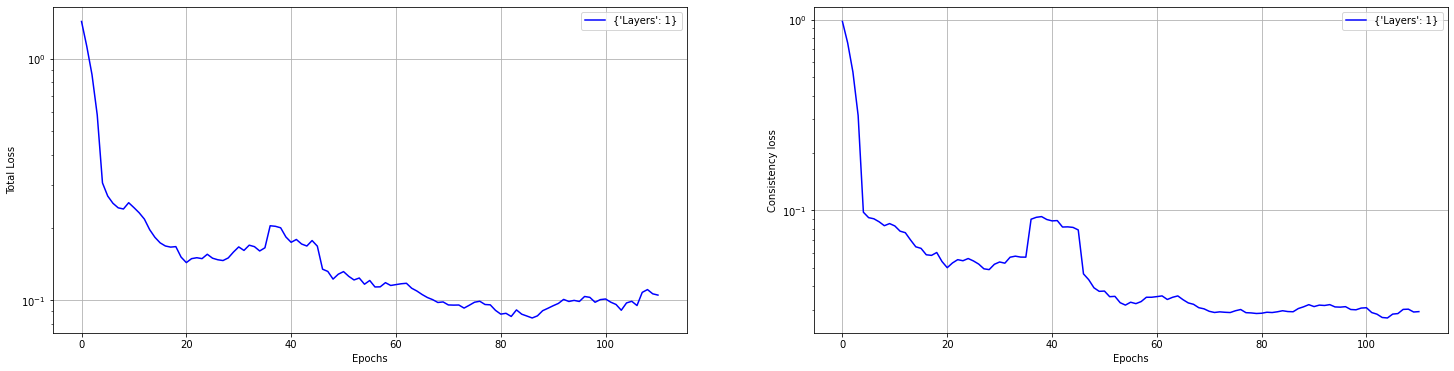

Generating 201 / 100 samples before starting training


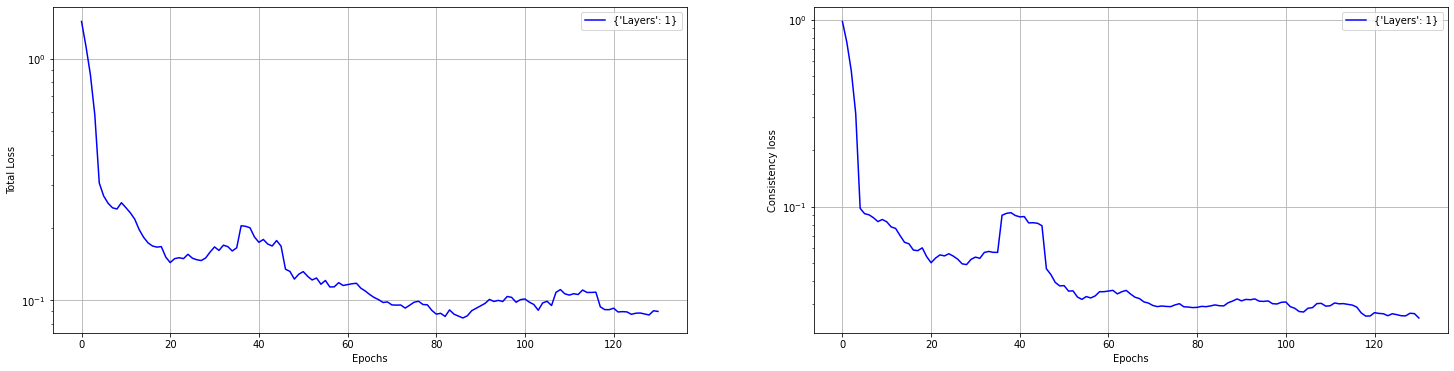

Generating 201 / 100 samples before starting training


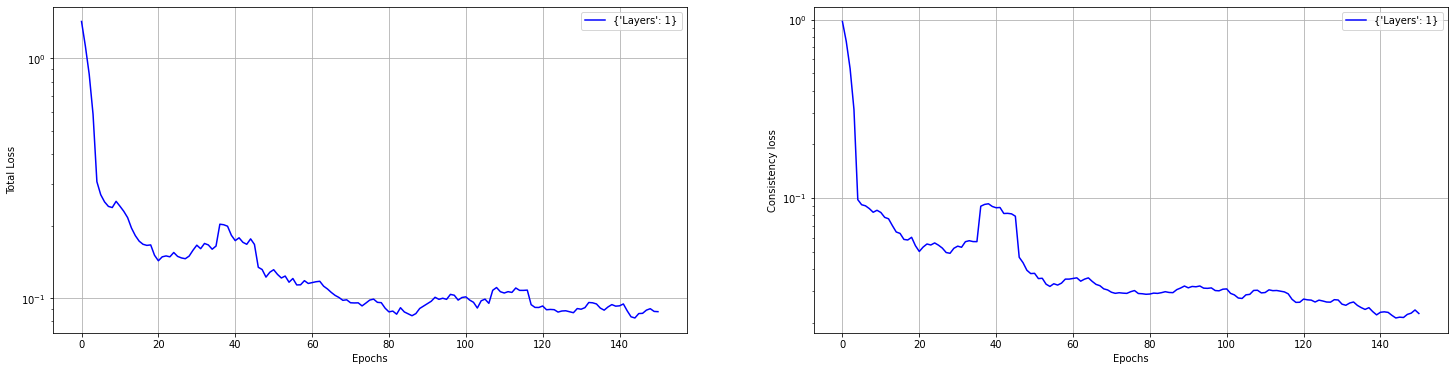

Generating 201 / 100 samples before starting training


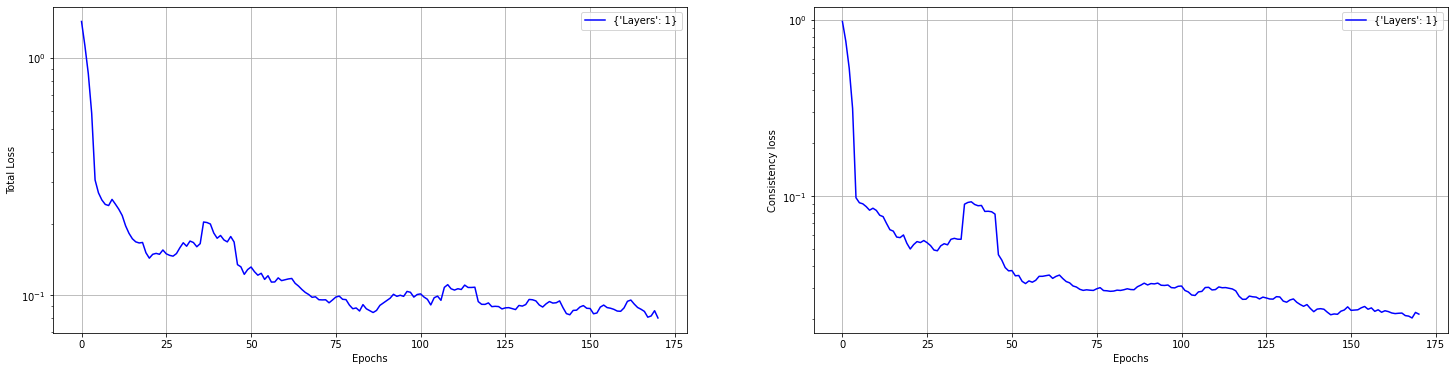

Generating 200 / 100 samples before starting training


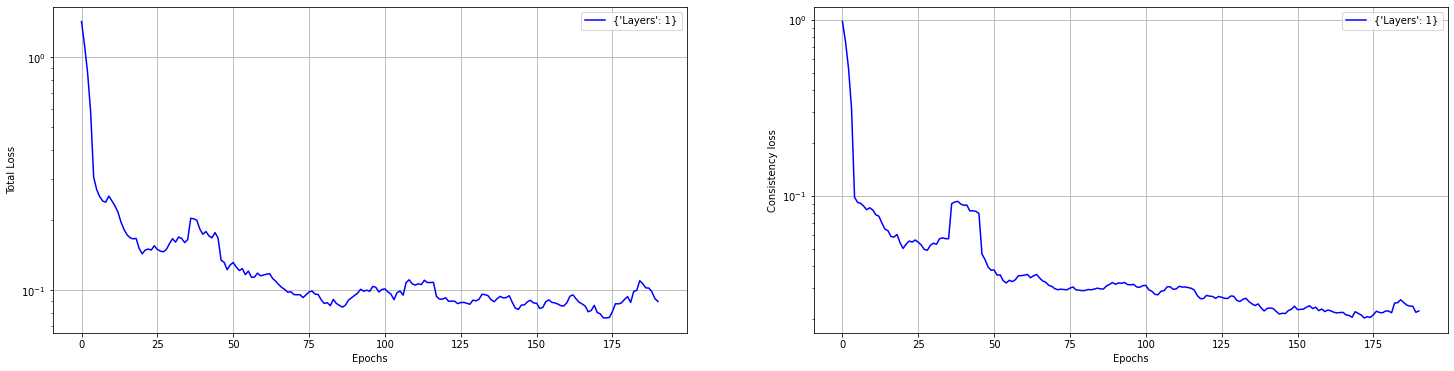

In [8]:
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = (cycler(color=list('bgrcmyk')))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()

for _ in range(10):
    with generator:
        for model in models:
            h = model.fit(generator, epochs=20, steps_per_epoch=100, verbose=0)
            save_progress(model, h)
        plot_progress(models)
        



In [9]:
for model in models:
    print(model.specs)
    model.summary()


{'Layers': 1}
Model: "lode_star_base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 29, 29, 4)         19940     
                                                                 
Total params: 19,940
Trainable params: 19,940
Non-trainable params: 0
_________________________________________________________________


In [10]:
def get_propagation_matrix(shape, to_z, pixel_size, wavelength):

    k = 2 * np.pi / wavelength
    yr, xr, *_ = shape

    x = 2 * np.pi / pixel_size * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / pixel_size * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return C * np.fft.fftshift(np.exp(k * 1j * to_z * (K - 1)))

def fourier_transform(image, padding=32):
    im = np.pad(image, ((padding, padding), (padding, padding)), mode="symmetric")
    return np.fft.fft2(im)

def inverse_fourier_transform(image, padding=32):
    im = np.fft.ifft2(image)
    return im[padding:-padding, padding:-padding]

def fourier_transform_transformation(image, Tz, Tzinv, i):
    if i < 0:
        image *= Tzinv ** np.abs(i)
    else:
        image *= Tz ** i
    return image

def propagate(image, z):
    """Re-propagate the images using PAS"""
    ft_image = fourier_transform(image[:,:,0])
    prop_ft_image = fourier_transform_transformation(ft_image, crop_propagation_backward, crop_propagation_forward, z)
    return np.expand_dims(inverse_fourier_transform(prop_ft_image),axis=-1)

{'Layers': 1}
PROPAGERADE BILDER


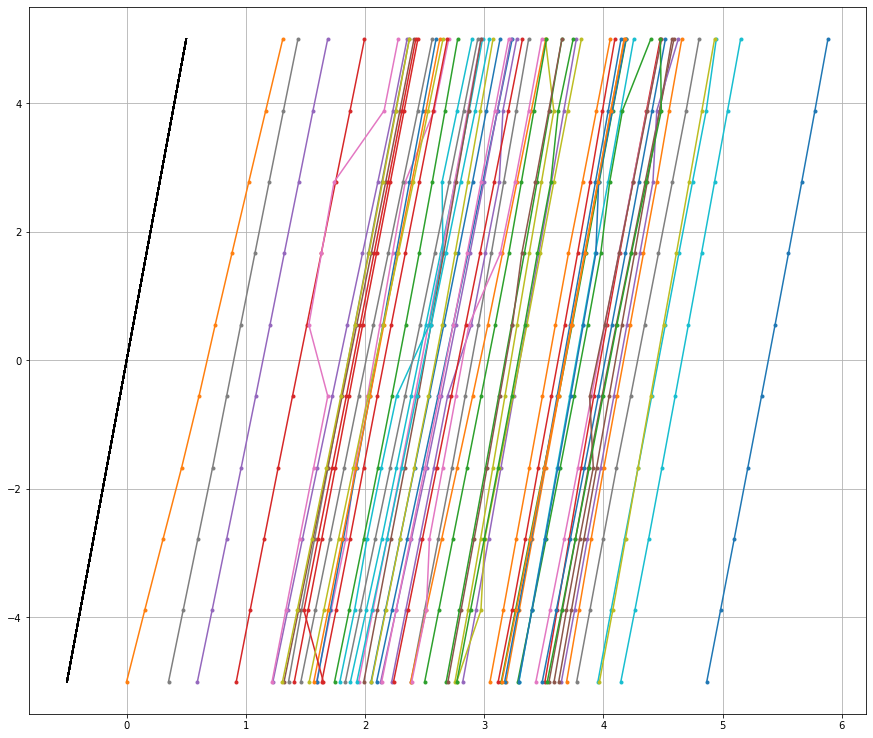

STD: 3.027


In [11]:
cc = (cycler(color=list('bgrcmyk')))

def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets)
    dets *= multfact
    #dets[:,2] = dets[:,2] - np.mean(dets[:,2])
    return dets

def reshape_dets(dets):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = IMAGE_SIZE//2, IMAGE_SIZE//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            out.append([0,0,0])
    return np.array(out)

def create_validation_stack(images, z_list):
    """"""
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]

def plot_preds(val_stack):
    for particle_id in range(from_id, from_id+num_samples):
        dets = model.predict_and_detect(val_stack[:,:,:,:], mode="ratio"), 
        plt.figure(figsize=(10, 10))
        plt.imshow(np.abs(val_stack[stack_id,:,:,0]+1j*val_stack[stack_id,:,:,1]), cmap="bone")
        dets = np.squeeze(np.array(dets))
        print(dets)
        plt.scatter(dets[stack_id,1], dets[stack_id,0], s=200, facecolor="none", linewidths=3, edgecolors="g")
        plt.show()
        
        dets[:,2] *= multfact
        #dets[:,2] -= np.mean(dets[:,2])
        #[print(d) for d in dets]

def evaluate_model(model, val_stack, prop_range):
    accs = []
    for i in range(num_samples):
        accs.append(predict_on_stack(model, val_stack[from_id+i])[:,2])
    accs = np.array(accs)
    accs = accs - np.min(accs)

    stds = []
    fig, ax = plt.subplots(1,1, figsize=(15,13))
    for i in range(accs.shape[0]):
        ax.plot(prop_range/10, prop_range, 'k')
        ax.plot(accs[i,:].flatten(), prop_range, '.-')
        ax.grid(True)
        stds.append(np.std(accs[i,:].flatten() - prop_range))
    plt.show()
    print(f"STD: {np.std((accs-prop_range).flatten()):.3f}", )

model = models[-1]
#for model in models:
prop_range = np.linspace(-5, 5, 10) #np.random.randn(70)
from_id = 0
num_samples = len(particles_positions[particle_id][:,0])
stack_id = len(prop_range)//2
multfact = -1
print(model.specs)
print("PROPAGERADE BILDER")
val_stack = create_validation_stack(validation_set, prop_range)
evaluate_model(model, val_stack, prop_range)

val_stack = np.stack( (np.real(validation_set[:,:,:,0]), np.imag(validation_set[:,:,:,0])), axis=-1)
corrections = predict_on_stack(model, val_stack)
x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], particles_positions[particle_id][:,2]
z_lode = z_lode/-10
z_lode = z_lode - np.mean(z_lode)
x_new, y_new, z_new = x_matlab+(32+x_lode)*0.114, y_matlab+(32+y_lode)*0.114, z_lode+z_matlab


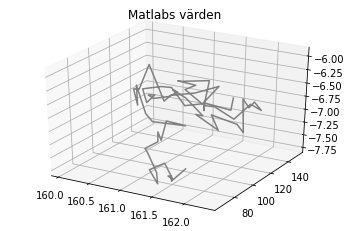

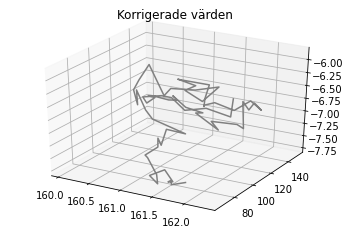

Matlab!


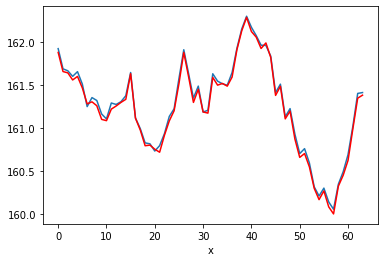

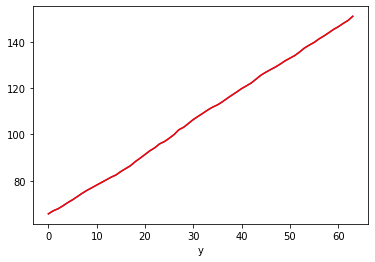

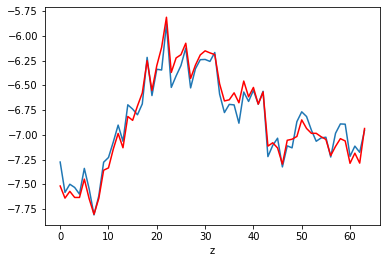

In [12]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.plot3D(x_matlab, y_matlab, z_matlab, 'gray')
ax.set_title("Matlabs värden")
plt.show()

ax = plt.axes(projection='3d')
ax.plot3D(x_matlab, y_matlab, z_matlab+z_lode, 'gray')
ax.set_title("Korrigerade värden")
plt.show()

print("Matlab!")
plt.plot(list(range(len(x_matlab))), x_matlab)
plt.xlabel("x")
plt.plot(list(range(len(x_lode))), x_new, 'r')
plt.show()

plt.plot(list(range(len(y_matlab))), y_matlab)
plt.plot(list(range(len(y_lode))), y_new, 'r')
plt.xlabel("y")
plt.show()

plt.plot(list(range(len(z_matlab))), z_matlab)
plt.plot(list(range(len(z_lode))), z_new, 'r')
plt.xlabel("z")
plt.show()

#https://journals.aps.org/pre/pdf/10.1103/PhysRevE.89.022726

In [13]:
def calc_sigma(arr):
    sigma2 = np.abs(np.mean(
        np.multiply(
            np.diff(arr[:-1]), 
            np.diff(arr[1:])
            )
    ))
    return np.sqrt(sigma2)

print(f"sigma_x_new: {calc_sigma(x_new):.3f}")
print(f"sigma_x_matlab: {calc_sigma(x_matlab):.3f}")
print(f"sigma_z_new: {calc_sigma(z_new):.3f}")
print(f"sigma_z_matlab: {calc_sigma(z_matlab):.3f}")


sigma_x_new: 0.082
sigma_x_matlab: 0.085
sigma_z_new: 0.100
sigma_z_matlab: 0.138


PARTICLE ID:  0
training images shape (16, 64, 64, 2)
validation images shape (16, 64, 64, 1)
Generating 100 / 100 samples before starting training


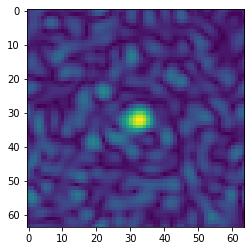

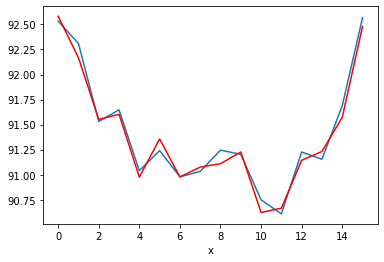

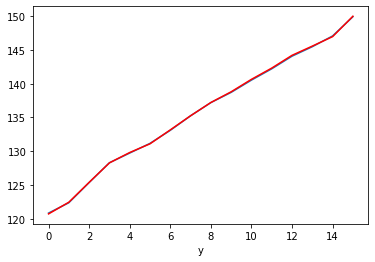

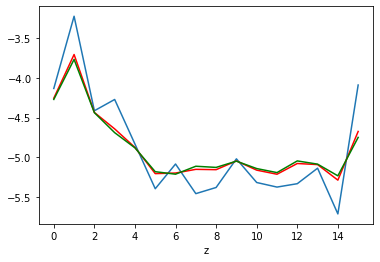

sigma_x_matlab: 0.122
sigma_x_new: 0.077

sigma_y_matlab: 1.927
sigma_y_new: 1.927

sigma_z_matlab: 0.417
sigma_z_new: 0.136
sigma_z_oil: 0.100
sigma_z_multfact: 0.030
z_mult: 1.4527569812742014

PARTICLE ID:  1
training images shape (17, 64, 64, 2)
validation images shape (17, 64, 64, 1)
Generating 100 / 100 samples before starting training


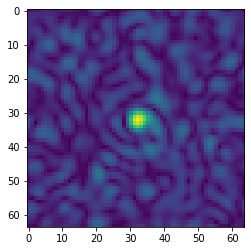

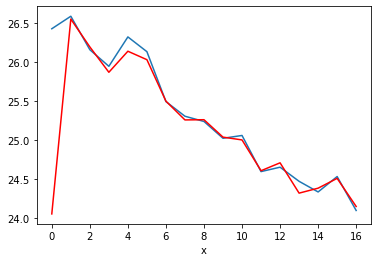

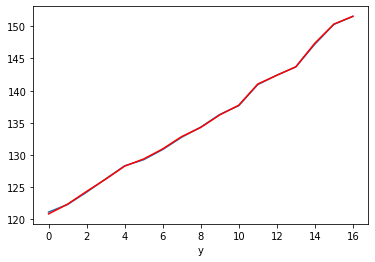

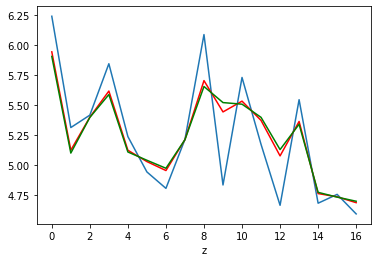

sigma_x_matlab: 0.025
sigma_x_new: 0.234

sigma_y_matlab: 1.931
sigma_y_new: 1.942

sigma_z_matlab: 0.483
sigma_z_new: 0.177
sigma_z_oil: 0.147
sigma_z_multfact: 0.134
z_mult: 1.3976537819333044

PARTICLE ID:  2
training images shape (17, 64, 64, 2)
validation images shape (17, 64, 64, 1)
Generating 101 / 100 samples before starting training


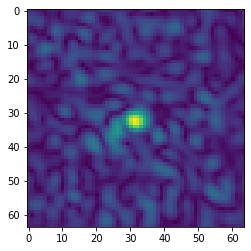

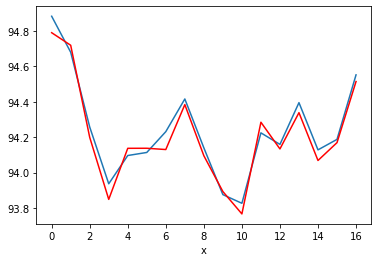

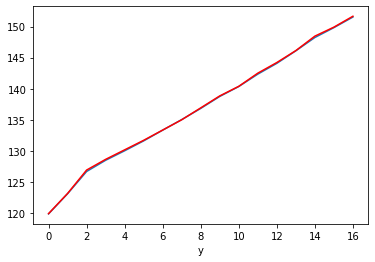

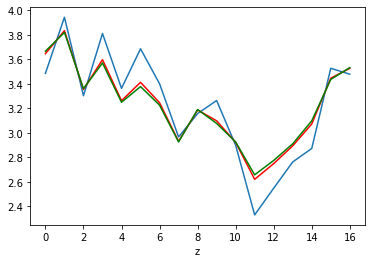

sigma_x_matlab: 0.087
sigma_x_new: 0.080

sigma_y_matlab: 1.986
sigma_y_new: 1.989

sigma_z_matlab: 0.241
sigma_z_new: 0.127
sigma_z_oil: 0.114
sigma_z_multfact: 0.069
z_mult: 1.9747383297884438

PARTICLE ID:  3
training images shape (33, 64, 64, 2)
validation images shape (33, 64, 64, 1)
Generating 101 / 100 samples before starting training


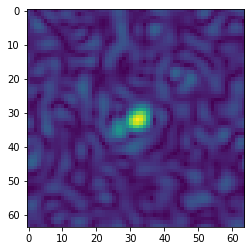

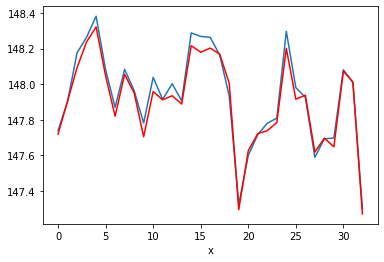

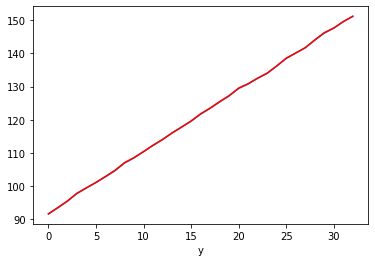

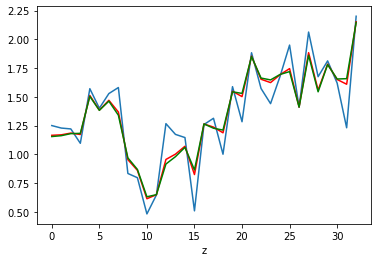

sigma_x_matlab: 0.072
sigma_x_new: 0.093

sigma_y_matlab: 1.861
sigma_y_new: 1.860

sigma_z_matlab: 0.278
sigma_z_new: 0.144
sigma_z_oil: 0.127
sigma_z_multfact: 0.064
z_mult: 2.07421059542094

PARTICLE ID:  4
training images shape (23, 64, 64, 2)
validation images shape (23, 64, 64, 1)
Generating 101 / 100 samples before starting training


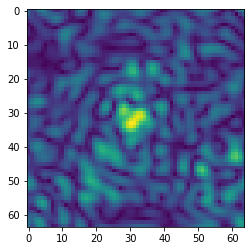

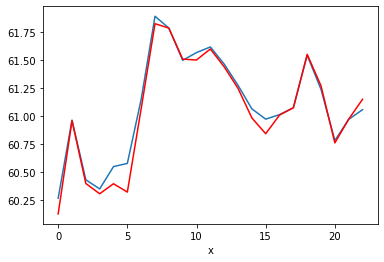

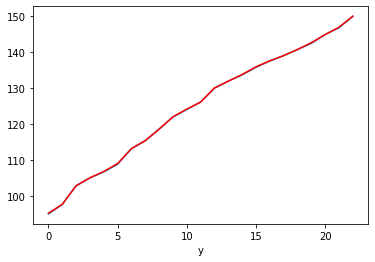

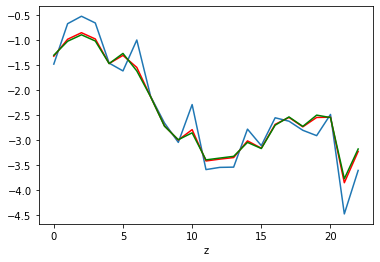

sigma_x_matlab: 0.059
sigma_x_new: 0.076

sigma_y_matlab: 2.480
sigma_y_new: 2.478

sigma_z_matlab: 0.440
sigma_z_new: 0.158
sigma_z_oil: 0.126
sigma_z_multfact: 0.078
z_mult: 1.4843894007484026

PARTICLE ID:  5
training images shape (29, 64, 64, 2)
validation images shape (29, 64, 64, 1)
Generating 101 / 100 samples before starting training


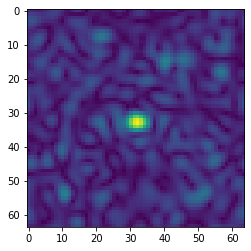

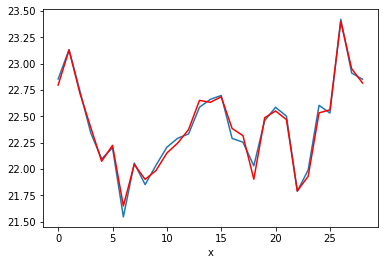

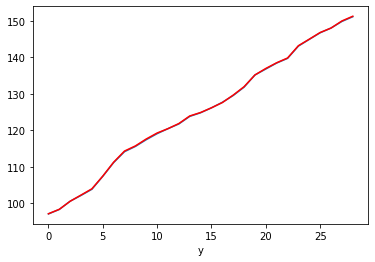

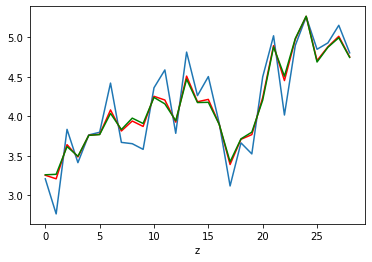

sigma_x_matlab: 0.181
sigma_x_new: 0.156

sigma_y_matlab: 1.999
sigma_y_new: 2.005

sigma_z_matlab: 0.395
sigma_z_new: 0.186
sigma_z_oil: 0.162
sigma_z_multfact: 0.092
z_mult: 1.75079045814709

PARTICLE ID:  6
training images shape (23, 64, 64, 2)
validation images shape (23, 64, 64, 1)
Generating 101 / 100 samples before starting training


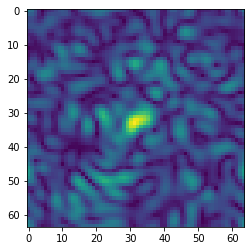

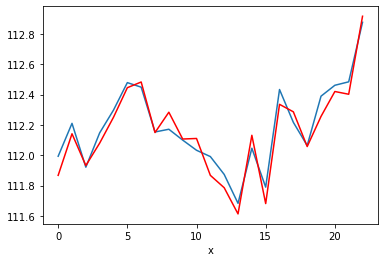

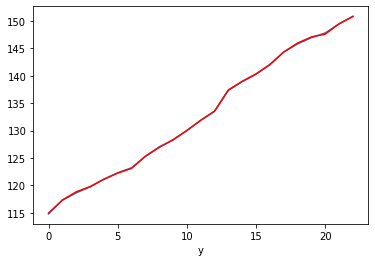

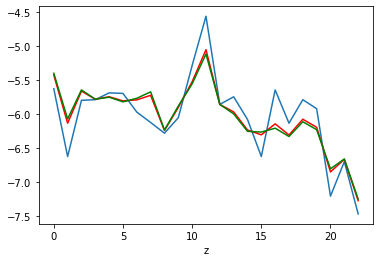

sigma_x_matlab: 0.152
sigma_x_new: 0.187

sigma_y_matlab: 1.631
sigma_y_new: 1.626

sigma_z_matlab: 0.384
sigma_z_new: 0.196
sigma_z_oil: 0.181
sigma_z_multfact: 0.169
z_mult: 1.4423823985572803

PARTICLE ID:  7
training images shape (18, 64, 64, 2)
validation images shape (18, 64, 64, 1)
Generating 100 / 100 samples before starting training


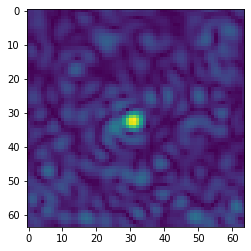

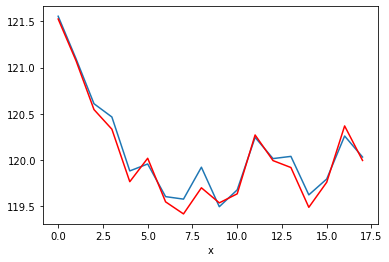

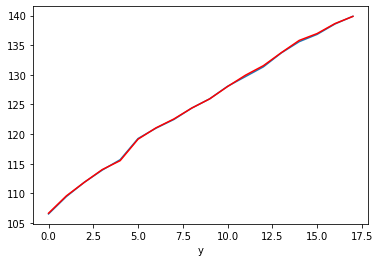

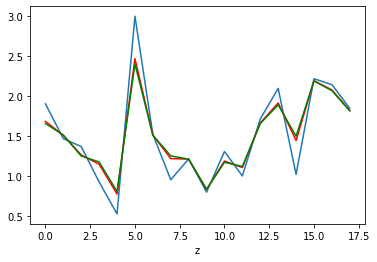

sigma_x_matlab: 0.060
sigma_x_new: 0.066

sigma_y_matlab: 1.954
sigma_y_new: 1.943

sigma_z_matlab: 0.605
sigma_z_new: 0.391
sigma_z_oil: 0.364
sigma_z_multfact: 0.273
z_mult: 2.5595615162784147

PARTICLE ID:  8
training images shape (19, 64, 64, 2)
validation images shape (19, 64, 64, 1)
Generating 100 / 100 samples before starting training


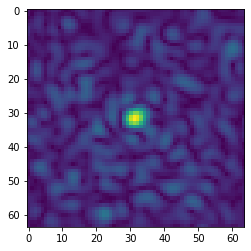

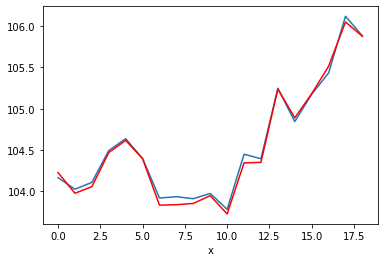

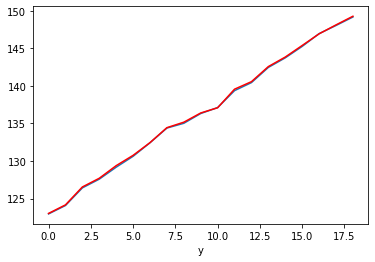

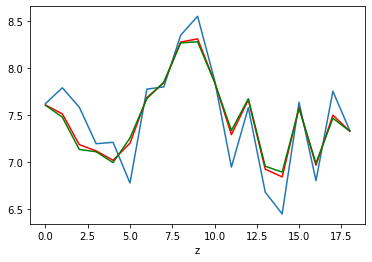

sigma_x_matlab: 0.163
sigma_x_new: 0.112

sigma_y_matlab: 1.442
sigma_y_new: 1.434

sigma_z_matlab: 0.431
sigma_z_new: 0.220
sigma_z_oil: 0.196
sigma_z_multfact: 0.134
z_mult: 1.7595593535068783

PARTICLE ID:  9
training images shape (32, 64, 64, 2)
validation images shape (32, 64, 64, 1)
Generating 100 / 100 samples before starting training


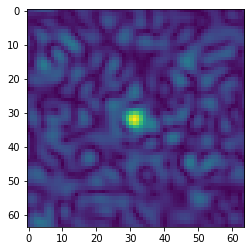

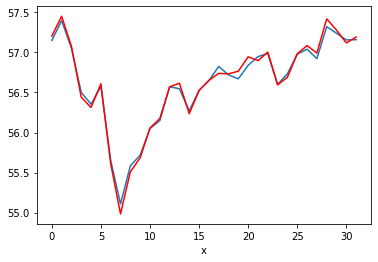

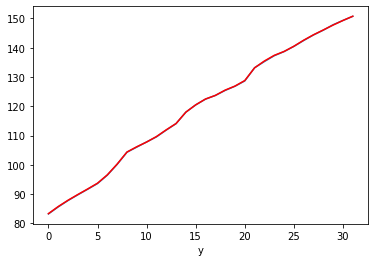

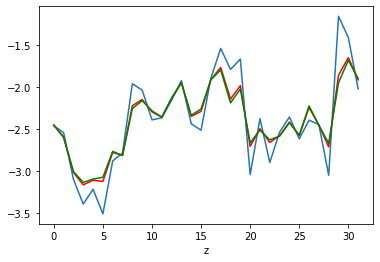

sigma_x_matlab: 0.092
sigma_x_new: 0.090

sigma_y_matlab: 2.232
sigma_y_new: 2.234

sigma_z_matlab: 0.321
sigma_z_new: 0.127
sigma_z_oil: 0.107
sigma_z_multfact: 0.078
z_mult: 1.4912196184364253

PARTICLE ID:  10
training images shape (64, 64, 64, 2)
validation images shape (64, 64, 64, 1)
Generating 100 / 100 samples before starting training


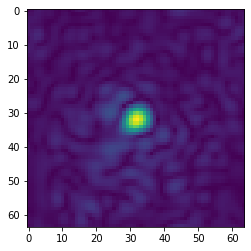

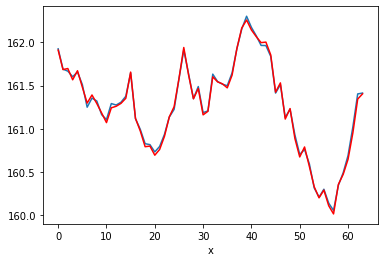

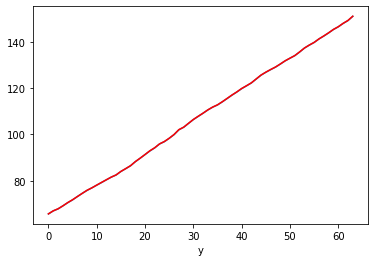

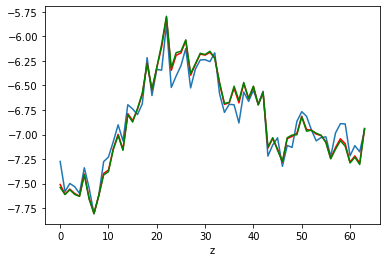

sigma_x_matlab: 0.085
sigma_x_new: 0.078

sigma_y_matlab: 1.351
sigma_y_new: 1.352

sigma_z_matlab: 0.138
sigma_z_new: 0.102
sigma_z_oil: 0.099
sigma_z_multfact: 0.091
z_mult: 1.8058963209190455

PARTICLE ID:  11
training images shape (16, 64, 64, 2)
validation images shape (16, 64, 64, 1)
Generating 100 / 100 samples before starting training


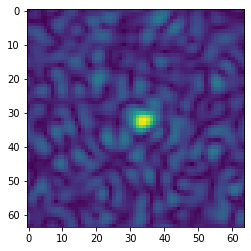

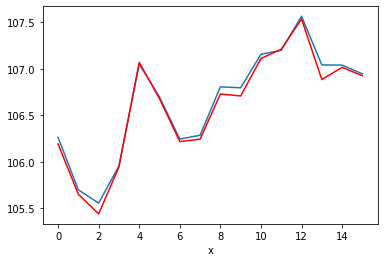

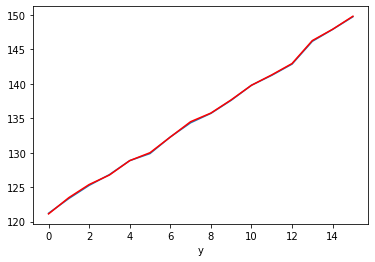

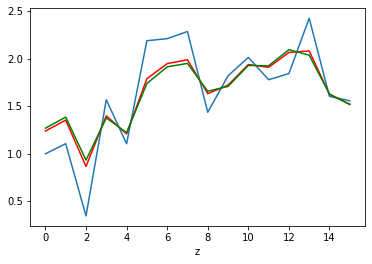

sigma_x_matlab: 0.070
sigma_x_new: 0.067

sigma_y_matlab: 1.872
sigma_y_new: 1.871

sigma_z_matlab: 0.450
sigma_z_new: 0.174
sigma_z_oil: 0.137
sigma_z_multfact: 0.059
z_mult: 1.928346549522099

PARTICLE ID:  12
training images shape (19, 64, 64, 2)
validation images shape (19, 64, 64, 1)
Generating 101 / 100 samples before starting training


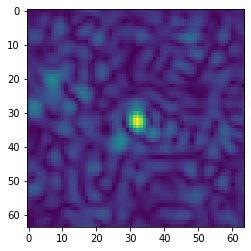

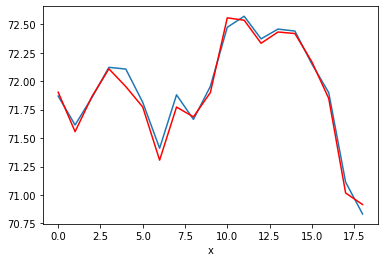

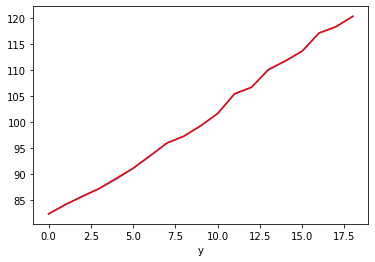

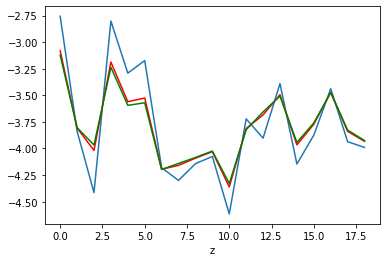

sigma_x_matlab: 0.159
sigma_x_new: 0.135

sigma_y_matlab: 2.081
sigma_y_new: 2.073

sigma_z_matlab: 0.391
sigma_z_new: 0.202
sigma_z_oil: 0.179
sigma_z_multfact: 0.101
z_mult: 1.9629460237713867

PARTICLE ID:  13
training images shape (18, 64, 64, 2)
validation images shape (18, 64, 64, 1)
Generating 100 / 100 samples before starting training


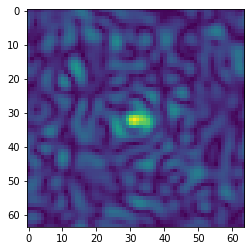

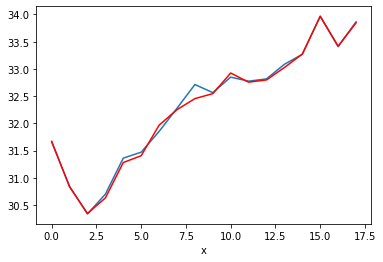

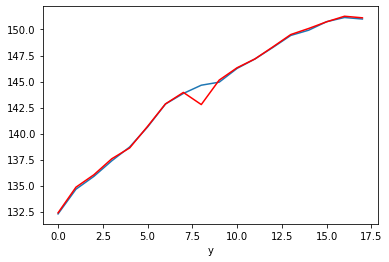

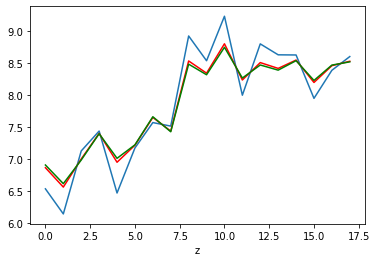

sigma_x_matlab: 0.146
sigma_x_new: 0.164

sigma_y_matlab: 1.172
sigma_y_new: 1.085

sigma_z_matlab: 0.492
sigma_z_new: 0.289
sigma_z_oil: 0.267
sigma_z_multfact: 0.203
z_mult: 1.9306104831195157

PARTICLE ID:  14
training images shape (21, 64, 64, 2)
validation images shape (21, 64, 64, 1)
Generating 100 / 100 samples before starting training


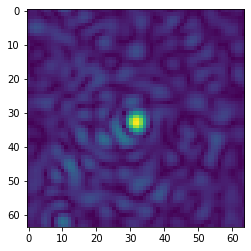

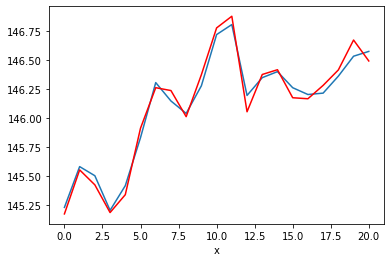

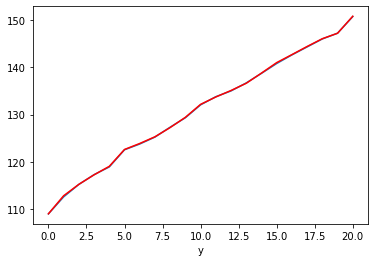

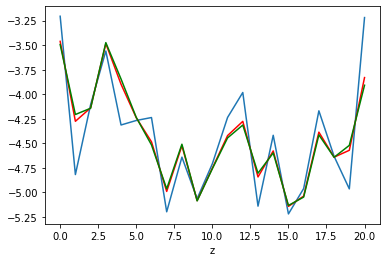

sigma_x_matlab: 0.095
sigma_x_new: 0.015

sigma_y_matlab: 1.997
sigma_y_new: 1.994

sigma_z_matlab: 0.479
sigma_z_new: 0.226
sigma_z_oil: 0.198
sigma_z_multfact: 0.131
z_mult: 1.6732226327735475

PARTICLE ID:  15
training images shape (81, 64, 64, 2)
validation images shape (81, 64, 64, 1)
Generating 100 / 100 samples before starting training


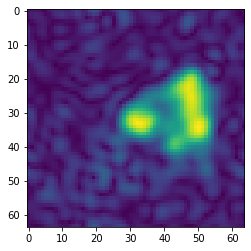

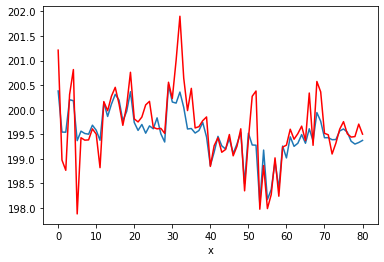

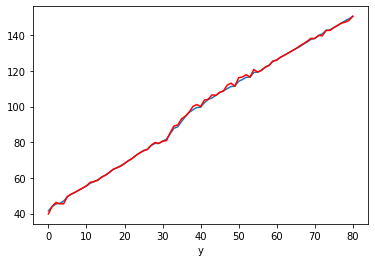

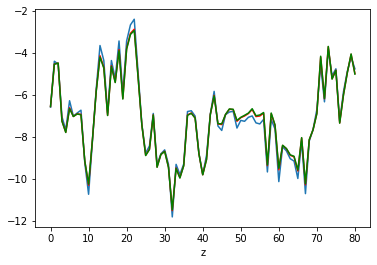

sigma_x_matlab: 0.297
sigma_x_new: 0.457

sigma_y_matlab: 1.338
sigma_y_new: 1.118

sigma_z_matlab: 0.698
sigma_z_new: 0.661
sigma_z_oil: 0.659
sigma_z_multfact: 0.652
z_mult: 1.8661556525891352

PARTICLE ID:  16
training images shape (16, 64, 64, 2)
validation images shape (16, 64, 64, 1)
Generating 100 / 100 samples before starting training


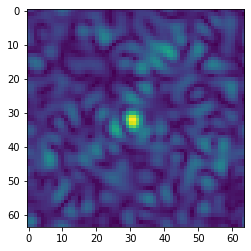

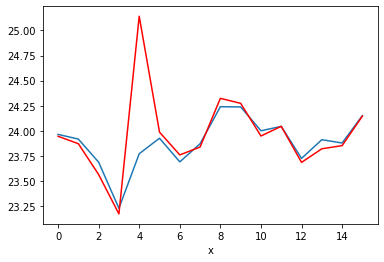

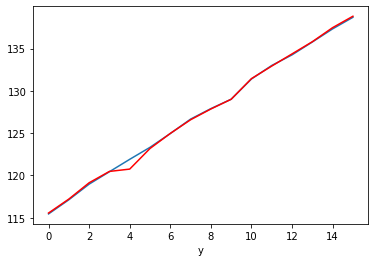

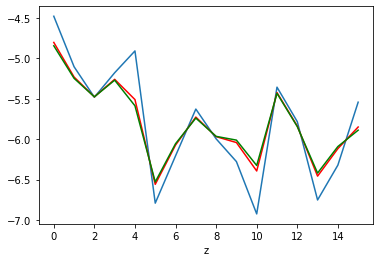

sigma_x_matlab: 0.107
sigma_x_new: 0.441

sigma_y_matlab: 1.547
sigma_y_new: 1.531

sigma_z_matlab: 0.410
sigma_z_new: 0.228
sigma_z_oil: 0.207
sigma_z_multfact: 0.140
z_mult: 1.9957318564418662

PARTICLE ID:  17
training images shape (90, 64, 64, 2)
validation images shape (90, 64, 64, 1)
Generating 100 / 100 samples before starting training


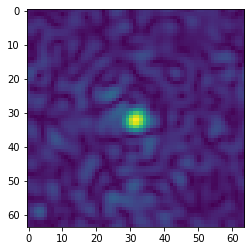

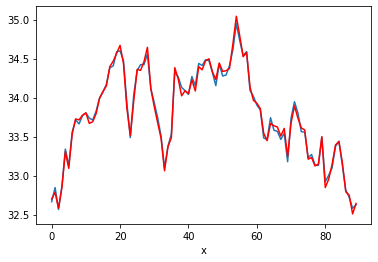

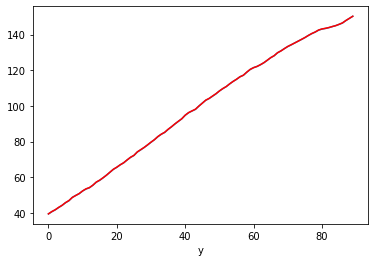

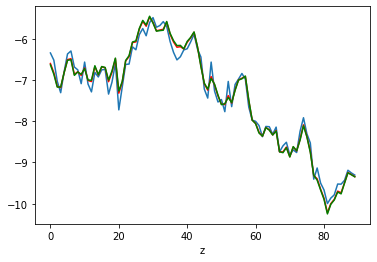

sigma_x_matlab: 0.036
sigma_x_new: 0.056

sigma_y_matlab: 1.262
sigma_y_new: 1.261

sigma_z_matlab: 0.154
sigma_z_new: 0.091
sigma_z_oil: 0.100
sigma_z_multfact: 0.110
z_mult: 2.3588496211884205

PARTICLE ID:  18
training images shape (16, 64, 64, 2)
validation images shape (16, 64, 64, 1)
Generating 100 / 100 samples before starting training


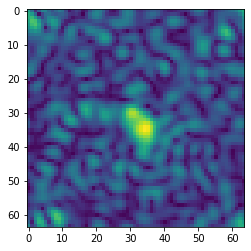

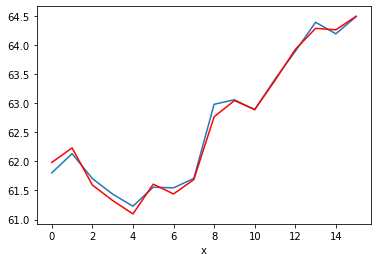

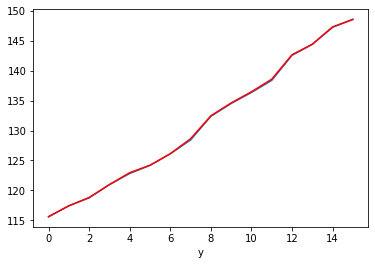

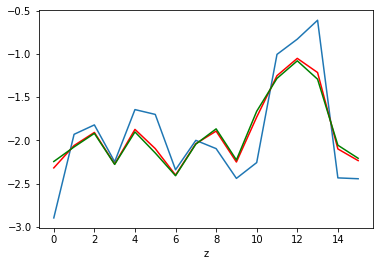

sigma_x_matlab: 0.187
sigma_x_new: 0.226

sigma_y_matlab: 2.226
sigma_y_new: 2.227

sigma_z_matlab: 0.163
sigma_z_new: 0.083
sigma_z_oil: 0.051
sigma_z_multfact: 0.172
z_mult: 0.37868164041567476

PARTICLE ID:  19
training images shape (17, 64, 64, 2)
validation images shape (17, 64, 64, 1)
Generating 100 / 100 samples before starting training


In [ ]:
from scipy.optimize import minimize

original_model = models[-1]
def compare_lode_matlab(val_stack):
    out_sigmas_new = []
    out_sigmas_matlab = []
    z_mults = []
    traces = []
    for particle_id in range(len(val_stack)//5):
        print("PARTICLE ID: ", particle_id)

        training_images = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
        print(f"training images shape {training_images.shape}")
        validation_set = particles_timeseries[particle_id][:,:,:,:]
        print(f"validation images shape {validation_set.shape}")

        training_set = create_training_set(training_images)

        generator = dt.models.lodestar.LodeSTARGenerator(
            training_set,
            num_outputs=num_outputs, 
            transformation_function=(group, equivariance), 
            batch_size=8, 
            min_data_size=100, 
            max_data_size=101,
        )

        model = original_model
        with generator:
            h = model.fit(generator, epochs=15, steps_per_epoch=50, verbose=0)


        timeseries = np.stack( (np.real(val_stack[particle_id][:,:,:,0]), np.imag(val_stack[particle_id][:,:,:,0])), axis=-1)
        corrections = predict_on_stack(model, timeseries)
        x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
        x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], particles_positions[particle_id][:,2]

        z_lode = z_lode/-10
        z_lode = z_lode - np.mean(z_lode)
        x_new, y_new, z_new = x_matlab+(32+x_lode)*0.114, y_matlab+(32+y_lode)*0.114, z_lode+z_matlab
        z_oil_maybe = z_matlab+z_lode*1.5/1.33
        z_shoudlnt = z_matlab+z_lode*1.6



        plt.imshow(np.abs(timeseries[0,:,:,0]+1j*timeseries[0,:,:,1]))
        plt.show()

        plt.plot(list(range(len(x_matlab))), x_matlab)
        plt.xlabel("x")
        plt.plot(list(range(len(x_lode))), x_new, 'r')
        plt.show()

        plt.plot(list(range(len(y_matlab))), y_matlab)
        plt.plot(list(range(len(y_lode))), y_new, 'r')
        plt.xlabel("y")
        plt.show()

        plt.plot(list(range(len(z_matlab))), z_matlab)
        plt.plot(list(range(len(z_lode))), z_new, 'r')
        plt.plot(list(range(len(z_oil_maybe))), z_oil_maybe, 'g')
        plt.xlabel("z")
        plt.show()

        print(f"sigma_x_matlab: {calc_sigma(x_matlab):.3f}")
        print(f"sigma_x_new: {calc_sigma(x_new):.3f}\n")

        print(f"sigma_y_matlab: {calc_sigma(y_matlab):.3f}")
        print(f"sigma_y_new: {calc_sigma(y_new):.3f}\n")

        print(f"sigma_z_matlab: {calc_sigma(z_matlab):.3f}")
        print(f"sigma_z_new: {calc_sigma(z_new):.3f}")
        print(f"sigma_z_oil: {calc_sigma(z_oil_maybe):.3f}")
        print(f"sigma_z_multfact: {calc_sigma(z_shoudlnt):.3f}")

        def sigma_z(x):
            arr = z_matlab + z_lode*x
            return calc_sigma(arr)

        z_mult = minimize(sigma_z, [1], method="Powell").x
        print(f"z_mult: {z_mult}\n")

        out_sigmas_new.append([calc_sigma(x_new), calc_sigma(y_new), calc_sigma(z_new)])
        out_sigmas_matlab.append([calc_sigma(x_matlab), calc_sigma(y_matlab), calc_sigma(z_matlab)])
        z_mults.append(z_mult)
        traces.append(np.array([x_matlab, y_matlab, z_new]))

    return np.array(out_sigmas_new), np.array(out_sigmas_matlab), z_mults, traces

new_sigmas, matlab_sigmas, z_mults, traces = compare_lode_matlab(particles_timeseries)
print(f"optimal mult.factor: {np.mean(z_mults)}")
# print(z_traces)

In [ ]:

def id_new_better_than_matlab(new_sigmas, matlab_sigmas):
    out = []
    for i in range(new_sigmas.shape[0]):
        #print(i, f"   {np.linalg.norm(new_sigmas[i,:])/np.linalg.norm(matlab_sigmas[i,:]):.2f}", f"   {np.linalg.norm(new_sigmas[i,2])/np.linalg.norm(matlab_sigmas[i,2]):.2f}")
        if np.linalg.norm(new_sigmas[i,2]) < np.linalg.norm(matlab_sigmas[i,2]):
            out.append(i)
    return out


#OPTIMAL MULT.FAKTOR: 1.600333833

bin = np.linspace(0,0.5,10)
ids = id_new_better_than_matlab(new_sigmas, matlab_sigmas)
print(len(ids), len(particles_timeseries))
print(f"korrigerad sigma_z: {np.mean(new_sigmas[ids,2])}, matlabs sigma_z: {np.mean(matlab_sigmas[ids,2])}")
print(np.mean(new_sigmas[ids,0]), np.mean(matlab_sigmas[ids,0]))

In [ ]:
def get_msd(x, max_dt=4):

    output = []
    for delt in range(max_dt):
        delta_x = x[1 + delt :] - x[: -(1 + delt)]
        
        th = 100 * np.sqrt(delt + 1)
        if np.any(delta_x > th):
            print(np.sum(delta_x > th))

        delta_x[delta_x > th] = 0
        squared_displacement = np.square(delta_x).sum(axis=-1)
        # superful fix här, för att den ska fungera för ensamma traces :----)
        if type(squared_displacement) == np.float32 or type(squared_displacement) == np.float64:
          length = 1
        else:
          length = len(squared_displacement)
        output.append(
            (
                np.mean(squared_displacement),
                np.std(squared_displacement),
                length,
            )
        )

    return np.array(output)

def fit_to_line(msd):
    return np.polyfit(range(1, msd.shape[0]+1), msd[:, 0], 1)

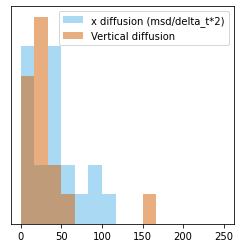

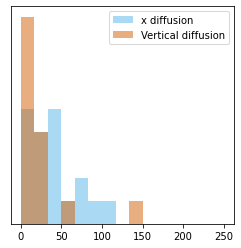

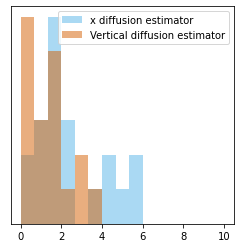

In [62]:
' DIFFUSION CALCULATIONS'

import seaborn
delta_time = 1/42
msds = []
msds_z = []



for pos in traces:
    msd = get_msd(pos[0,:], 10) 
    a, b = fit_to_line(msd[:4])
    msds.append(a)

    msd_z = get_msd(pos[2,:], 10)
    a, b = fit_to_line(msd_z[:4])
    msds_z.append(a)
# print(np.array(msds) / delta_time)
# print(np.array(msds_z) / delta_time)

plt.figure(figsize=(4, 4))
plt.hist(np.array(msds) / delta_time / 2, 15, range=(0, 250), alpha=0.5, facecolor=seaborn.color_palette("colorblind")[9])
plt.hist(np.array(msds_z) / delta_time / 2, 15, range=(0, 250), alpha=0.5, facecolor=seaborn.color_palette("colorblind")[3])
plt.yticks([])
plt.legend(["x diffusion (msd/delta_t*2)", "Vertical diffusion", ])

"Diffusion with sigma"
D_x = (msds-2*(calc_sigma(x_new)))/(2*delta_time)
D_z = (msds_z-2*np.mean(new_sigmas[ids,2]))/(2*delta_time)
plt.figure(figsize=(4, 4))
plt.hist(D_x, 15, range=(0, 250), alpha=0.5, facecolor=seaborn.color_palette("colorblind")[9])
plt.hist(D_z, 15, range=(0, 250), alpha=0.5, facecolor=seaborn.color_palette("colorblind")[3])
plt.yticks([])
plt.legend(["x diffusion", "Vertical diffusion", ])


"Diffusion estimator"
delta_z = []
delta_x = []

for pos in traces:
  z = pos[2,:]
  x = pos[0,:]
  delta_z.append([z[1 :] - z[: -1]])
  delta_x.append([x[1 :] - x[: -1]])


D_estimator_z = []
D_estimator_x = []
for i in range(len(delta_z)):
  delta_z_ = np.transpose(np.array(delta_z[i]))
  delta_x_ = np.transpose(np.array(delta_x[i]))
  D_z = np.mean(np.square(delta_z[i]))/(2*delta_time) + np.mean(delta_z_[:-1]*delta_z_[1:])/delta_time
  D_x = np.mean(np.square(delta_x[i]))/(2*delta_time) + np.mean(delta_x_[:-1]*delta_x_[1:])/delta_time
  D_estimator_z.append(D_z)
  D_estimator_x.append(D_x)

plt.figure(figsize=(4, 4))
plt.hist(D_estimator_x, 15, range=(0, 10), alpha=0.5, facecolor=seaborn.color_palette("colorblind")[9])
plt.hist(D_estimator_z, 15, range=(0, 10), alpha=0.5, facecolor=seaborn.color_palette("colorblind")[3])
plt.yticks([])
plt.legend(["x diffusion estimator", "Vertical diffusion estimator", ])